# This is a pipeline to visualize and analyze the results of CellProfiler on inmunohistochemistry experiments done for PH3

In [30]:
# Import stuff
%load_ext autoreload
%autoreload 2
import os
from utils import data_reader
from utils import plot_utils
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
#from ggplot import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# Select the path where the data is (the output of CellProfiler)
CPoutput_path = '/mnt/c/Users/herny/Desktop/SWC/Data/Microscopy_Data/Plasticity/PH3_inmuno/Cell_profiler_output/'


In [51]:
# Import the data
df = data_reader.PH3_data_reader(CPoutput_path)

In [11]:
# Rename channels
#df = df.rename(columns={"Children_FinalDots_C2_Count": "drd2_count",
#                        "Children_FinalDots_C3_Count": "drd1_count"})

In [52]:
df

AnimalID ExperimentalCondition Slide Slice Side    AP ROI  ObjectNumber  \
0        A2A01                    95     1     4    L  Tail  10             1   
1        A2A01                    95     1     4    L  Tail  10             2   
2        A2A01                    95     1     4    L  Tail  10             3   
3        A2A01                    95     1     4    L  Tail  10             4   
4        A2A01                    95     1     4    L  Tail  10             5   
...        ...                   ...   ...   ...  ...   ...  ..           ...   
23035    A2A01                    95     1     8    L  Tail   9           155   
23036    A2A01                    95     1     8    L  Tail   9           156   
23037    A2A01                    95     1     8    L  Tail   9           157   
23038    A2A01                    95     1     8    L  Tail   9           158   
23039    A2A01                    95     1     8    L  Tail   9           159   

       MedianI_C2  MedianI_C3  MedianI_C4     Center_X     Center_Y  \
0        0.666667    0.360784    0.270588   779.929769    41.686705   
1        0.282353    0.145098    0.298039   218.623826    40.593720   
2        0.615686    0.152941    0.239216   963.737354    48.964008   
3        0.643137    0.203922    0.247059  1181.392467    59.442802   
4        0.615686    0.258824    0.258824  1433.949449    58.220068   
...           ...         ...         ...          ...          ...   
23035    0.349020    0.529412    0.235294   457.225393  1540.829198   
23036    0.215686    0.290196    0.274510  1173.799794  1539.697292   
23037    0.396078    0.560784    0.266667   639.479819  1547.089074   
23038    0.258824    0.454902    0.258824  1276.938104  1549.335305   
23039    0.352941    0.243137    0.280392   125.814716  1562.722408   

                                       PathName_Channel1  
0      C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
1      C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
2      C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
3      C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
4      C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
...                                                  ...  
23035  C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
23036  C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
23037  C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
23038  C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  
23039  C:\Users\herny\Desktop\SWC\Data\Microscopy_Dat...  

[23040 rows x 14 columns]

***
### Sanity checks on the data
***

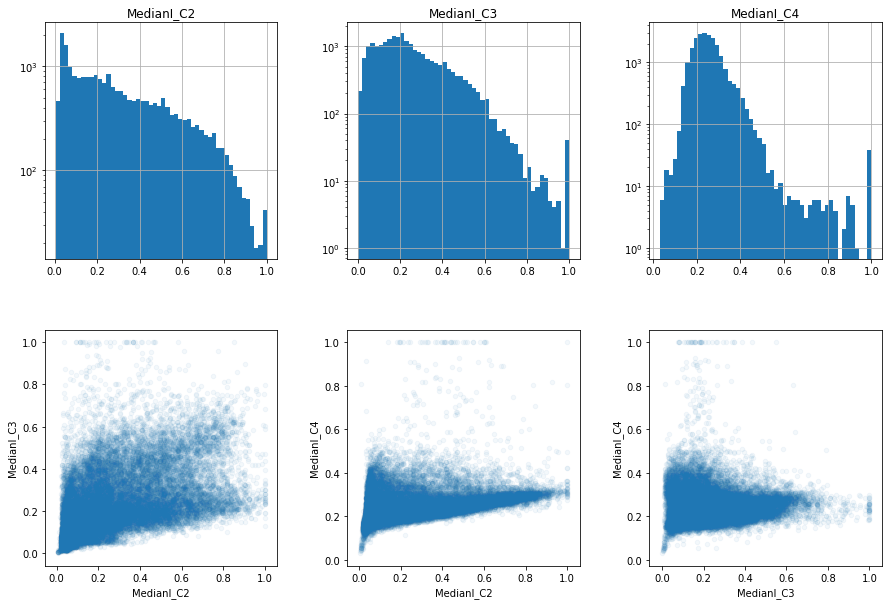

In [53]:
# plot histograms of counts for all the cells
channels = ["MedianI_C2", "MedianI_C3", "MedianI_C4"]
%matplotlib inline
fig, axs = plt.subplots(2, ncols=3, sharey=False, figsize=(15,10))
axs = axs.ravel()
axArr = [axs[0], axs[1], axs[2]]
i = 0
for axis in axArr:
    df.hist(channels[i], ax = axis, bins=50)
    #sns.distplot(df[channels[i]], ax = axis)
    axis.set_yscale("log")
    #axis.set_ylim(0,1000)
    axis.set_title(channels[i])
    i+=1
df.plot.scatter(channels[0],channels[1], ax = axs[3], alpha = 0.05)
df.plot.scatter(channels[0],channels[2], ax = axs[4], alpha = 0.05)
df.plot.scatter(channels[1],channels[2], ax = axs[5], alpha = 0.05)

In [49]:
df.shape

(23040, 14)

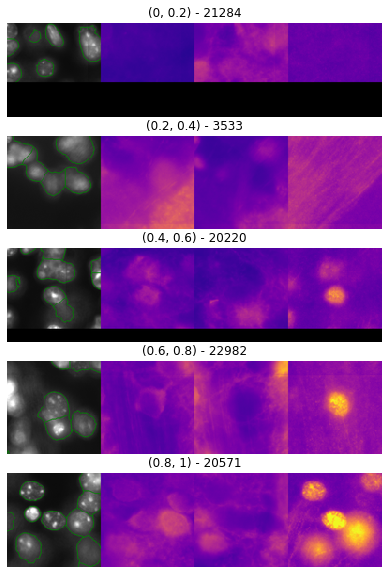

In [58]:
# find which cells are SPNs. Explore the threshold
sc = 'MedianI_C4'
# plot randomly sets of cells within certain values of channel 2, which is DARPP-32
thresholds = ((0, .2), (.2, .4), (.4, .6), (.6, .8), (.8, 1))
#create an empty list
indexes = []
# get the indexes of these cohorts
for tr in thresholds:
    shuffledIdx = df[np.logical_and(df[sc]>=tr[0], df[sc]<tr[1])].index.values
    # shuffle them
    np.random.shuffle(shuffledIdx)
    # append first
    indexes.append(shuffledIdx[0])
fig = plt.subplots(sharey=False, figsize=(15,np.ceil(2*len(thresholds))))
for counter, i in enumerate(indexes):
    CellImage = plot_utils.plotPH3Cell(df.iloc[i], CPoutput_path, window=130, lut='plasma')
    plt.subplot(len(thresholds), 1, counter+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(str(thresholds[counter]) + " - " + str(i))
    plt.imshow(CellImage)

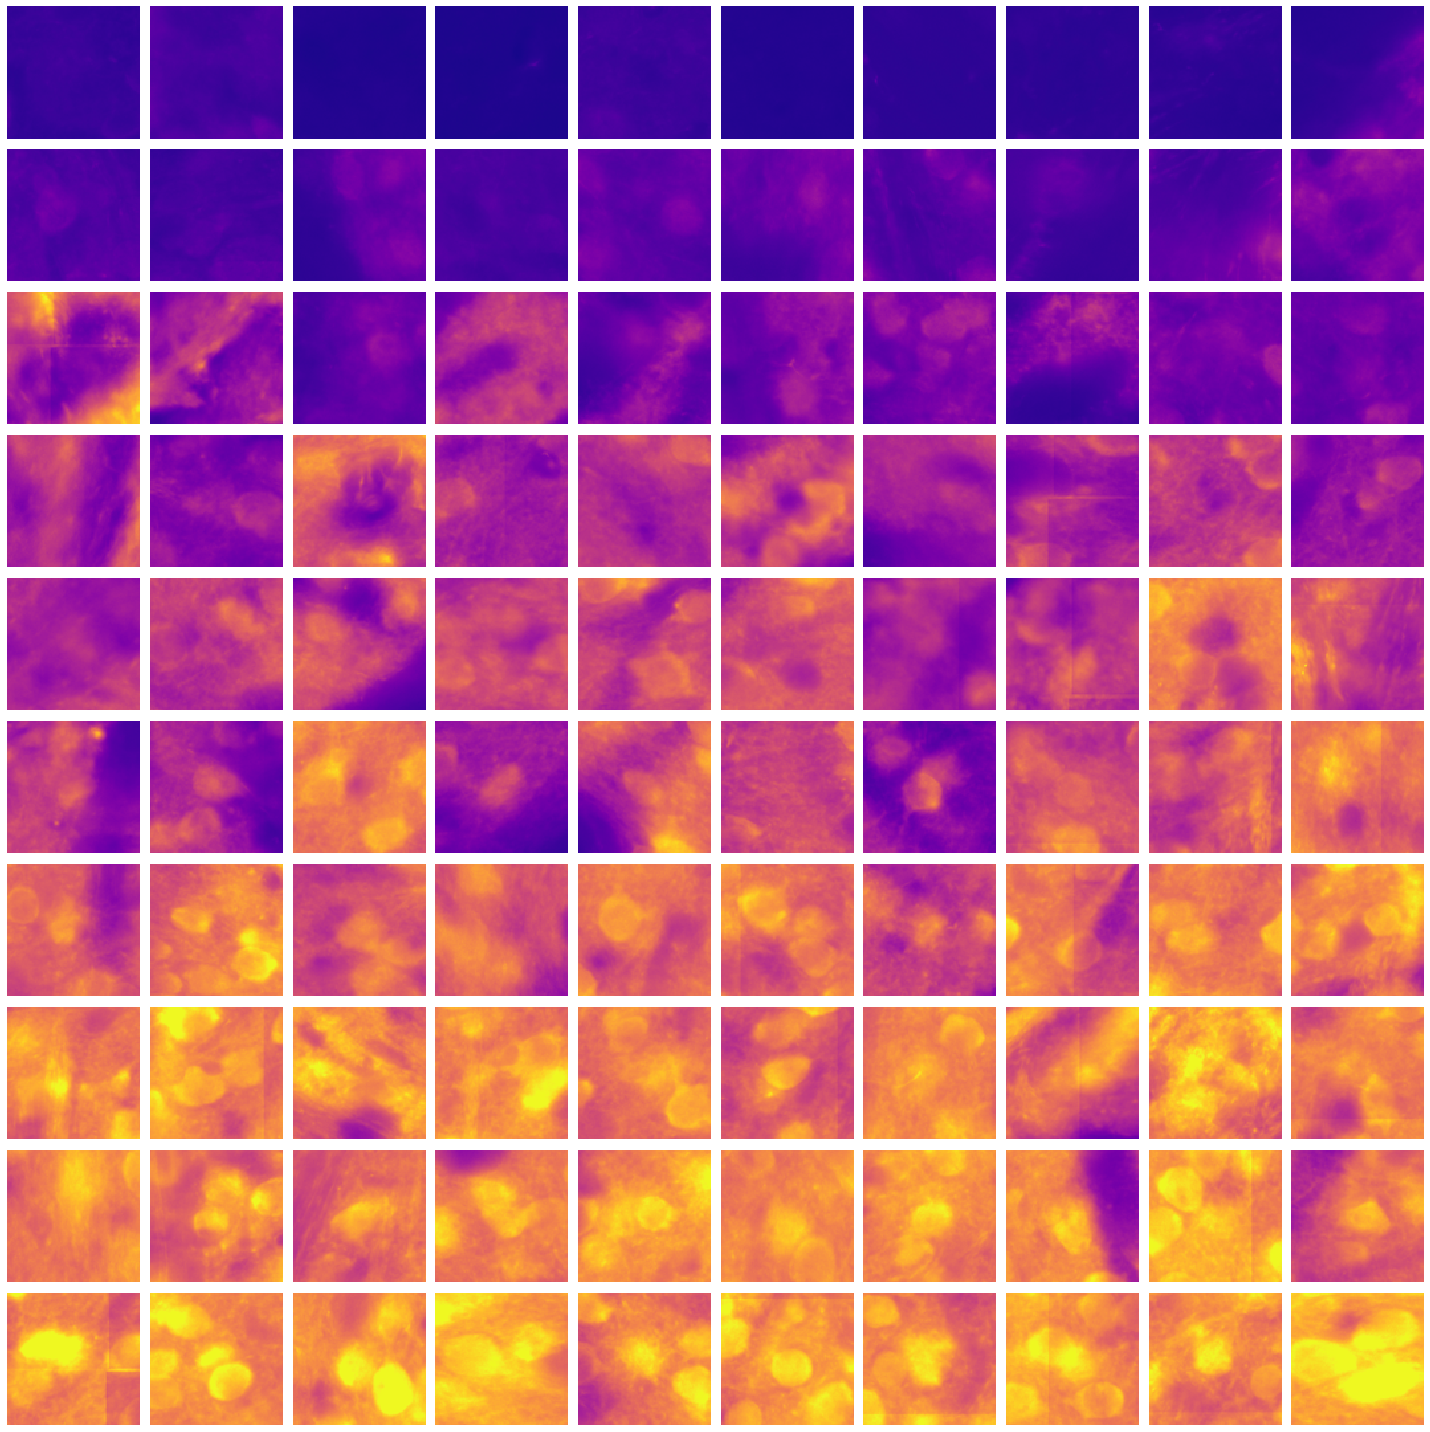

In [46]:
# plot just one channel
channel = 2
ncells = 10
sc = 'MedianI_C' + str(channel)
# plot randomly sets of cells within certain values of channel 2, which is DARPP-32
thresholds = ((0, .1), (.1, .2), (.2, .3), (.3, .4), (.4, .5),
              (.5, .6), (.6, .7), (.7, .8), (.8, .9), (.9, 1))
#create an empty list
indexes = []
# get the indexes of these cohorts
for tr in thresholds:
    shuffledIdx = df[np.logical_and(df[sc]>=tr[0], df[sc]<tr[1])].index.values
    # shuffle them
    np.random.shuffle(shuffledIdx)
    # append
    for item in shuffledIdx[0:ncells]:
        indexes.append(item)

fig = plt.subplots(sharey=False, figsize=(np.ceil(2*ncells), np.ceil(2*len(thresholds))))
for counter, i in enumerate(indexes):
    CellImage = plot_utils.plotPH3Channel(df.iloc[i], channel=channel, window=130, lut='plasma')
    plt.subplot(len(thresholds), ncells, counter+1)
    plt.grid(False)
    plt.axis('off')
    #plt.title(str(thresholds[counter]) + " - " + str(i))
    plt.imshow(CellImage)
plt.tight_layout()
plt.show()

In [119]:
# select a criteria for what is an SPN
SPN_thr = .5
dfsel = df[df.MedianI_C2 >= SPN_thr]
dfsel.shape

(4899, 14)

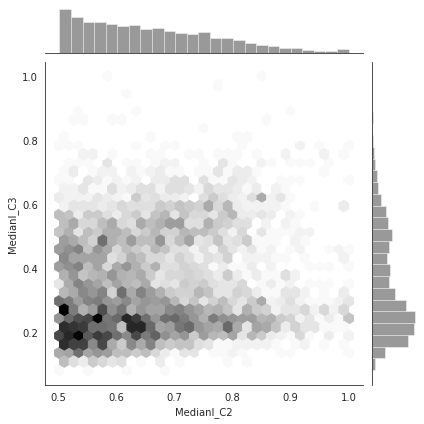

In [120]:
# plot the distribution to select a threshold for which ones are d1 and which ones d2
%matplotlib inline
pal = sns.cubehelix_palette(light=1, as_cmap=True)
with sns.axes_style("white"):
    sns.jointplot(x='MedianI_C2',
                  y='MedianI_C3',
                  data=dfsel,
                  kind="hex",
                  #bins='log',
                  # cmap=pal,
                  joint_kws=dict(gridsize=30),
                  color='k',
                  ratio=6,
                  marginal_kws=dict(bins=25, rug=False))


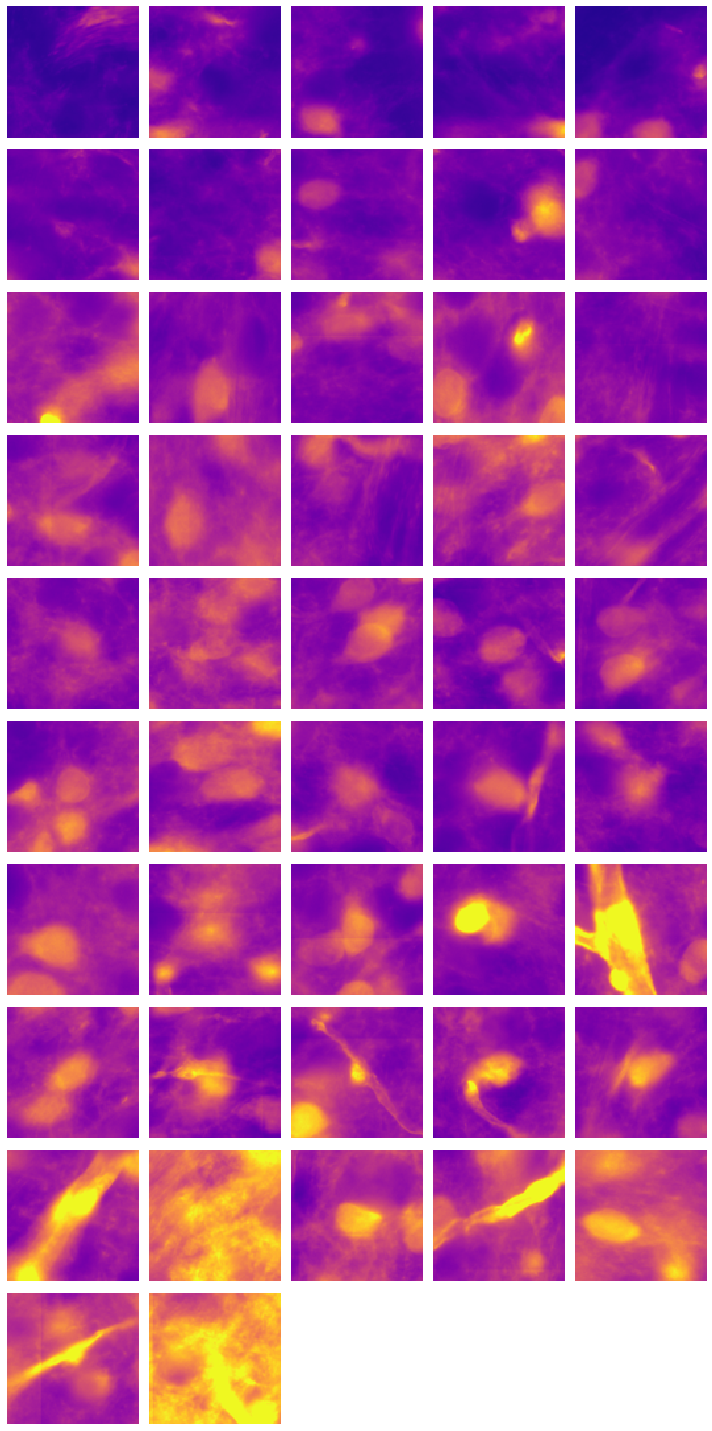

In [125]:
# see the tdtomato cells
channel = 3
ncells = 5
sc = 'MedianI_C' + str(channel)
# plot randomly sets of cells within certain values of channel 2, which is DARPP-32
thresholds = ((0, .1), (.1, .2), (.2, .3), (.3, .4), (.4, .5),
              (.5, .6), (.6, .7), (.7, .8), (.8, .9), (.9, 1))
#create an empty list
indexes = []
# get the indexes of these cohorts
for tr in thresholds:
    shuffledIdx = dfsel[np.logical_and(dfsel[sc]>=tr[0], dfsel[sc]<tr[1])].index.values
    # shuffle them
    np.random.shuffle(shuffledIdx)
    # append
    for item in shuffledIdx[0:ncells]:
        indexes.append(item)

fig = plt.subplots(sharey=False, figsize=(np.ceil(2*ncells), np.ceil(2*len(thresholds))))
for counter, i in enumerate(indexes):
    CellImage = plot_utils.plotPH3Channel(dfsel.loc[i], channel=channel, window=130, lut='plasma')
    plt.subplot(len(thresholds), ncells, counter+1)
    plt.grid(False)
    plt.axis('off')
    #plt.title(str(thresholds[counter]) + " - " + str(i))
    plt.imshow(CellImage)
plt.tight_layout()
plt.show()

In [126]:
tdtomato_thr = .3
100 * sum(dfsel.MedianI_C3 > tdtomato_thr) / dfsel.shape[0]

50.03061849357012

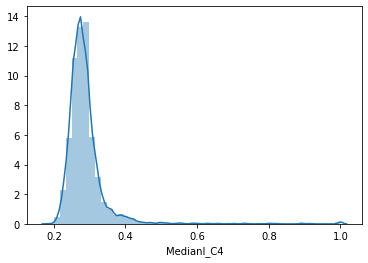

In [127]:
# plot the distribution to select a threshold for which ones are PH3+
ax = sns.distplot(dfsel.MedianI_C4)
#ax.set_yscale('log')

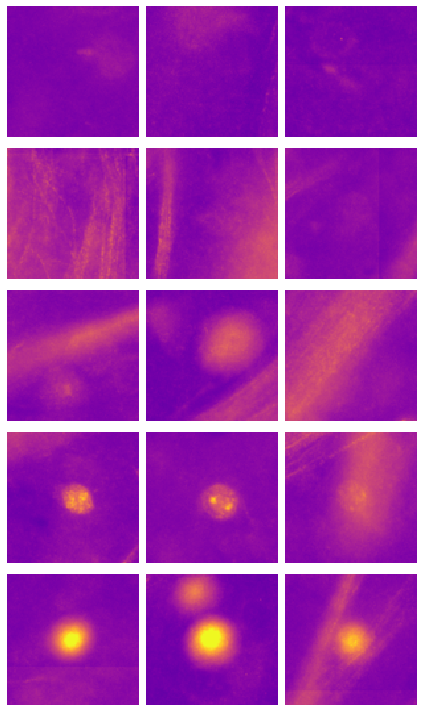

In [128]:
# find which cells are PH3 positive
# see the tdtomato cells
channel = 4
ncells = 3
sc = 'MedianI_C' + str(channel)
# plot randomly sets of cells within certain values of channel 2, which is DARPP-32
thresholds = ((.2, .3), (.3, .4), (.4, .5),
              (.5, .7), (.7, 1))
#create an empty list
indexes = []
# get the indexes of these cohorts
for tr in thresholds:
    shuffledIdx = dfsel[np.logical_and(dfsel[sc]>=tr[0], dfsel[sc]<tr[1])].index.values
    # shuffle them
    np.random.shuffle(shuffledIdx)
    # append
    for item in shuffledIdx[0:ncells]:
        indexes.append(item)

fig = plt.subplots(sharey=False, figsize=(np.ceil(2*ncells), np.ceil(2*len(thresholds))))
for counter, i in enumerate(indexes):
    CellImage = plot_utils.plotPH3Channel(dfsel.loc[i], channel=channel, window=130, lut='plasma')
    plt.subplot(len(thresholds), ncells, counter+1)
    plt.grid(False)
    plt.axis('off')
    #plt.title(str(thresholds[counter]) + " - " + str(i))
    plt.imshow(CellImage)
plt.tight_layout()
plt.show()

In [129]:
# percent of positive cells in the selected dataset (SPNs)
ph3_thr = .5
dfselsel = dfsel[dfsel.MedianI_C4 >= ph3_thr]
100 * dfselsel.shape[0] / dfsel.shape[0]

1.1022657685241886

In [130]:
# percent of what would be the total PH3+ cells
100 * dfselsel.shape[0] / sum(df.MedianI_C4 >= ph3_thr)

25.83732057416268

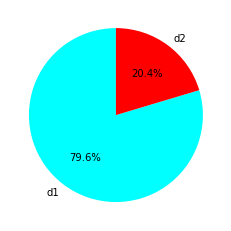

In [131]:
nd2 = sum(dfselsel.MedianI_C3 >= tdtomato_thr)
nd1 = sum(dfselsel.MedianI_C3 < tdtomato_thr)
ax = plt.pie([nd1, nd2], labels=['d1', 'd2'], colors=['cyan', 'red'],
             autopct='%1.1f%%', shadow=False, startangle=90)

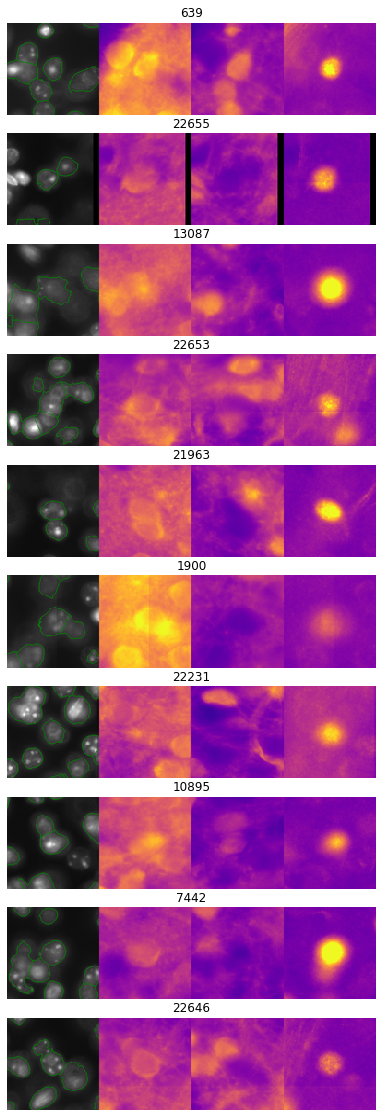

In [137]:
# plot some of the cells
ncells = 10
shuffledIdx = dfselsel.index.values
# shuffle them
np.random.shuffle(shuffledIdx)
shuffledIdx = shuffledIdx[0:ncells]
fig = plt.subplots(sharey=False, figsize=(15,np.ceil(2*ncells)))
for counter, i in enumerate(shuffledIdx):
    CellImage = plot_utils.plotPH3Cell(dfselsel.loc[i], CPoutput_path, window=130, lut='plasma')
    plt.subplot(ncells, 1, counter+1)
    plt.grid(False)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(CellImage)